VÍ DỤ A2:

In [20]:
import pandas as pd
import numpy as np

# Đọc file CSV
df = pd.read_csv("/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab7/pd_speech_features.csv")

print(df.columns[:10])

X = df.drop(columns=['class', 'id'], errors='ignore').values  
y = df['class'].values
print("Kích thước dữ liệu:", X.shape, "→ Số mẫu:", X.shape[0], " Số thuộc tính:", X.shape[1])


Index(['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter'],
      dtype='object')
Kích thước dữ liệu: (756, 753) → Số mẫu: 756  Số thuộc tính: 753


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=500, random_state=42, stratify=y,
)


In [22]:
# LDA thủ công
classes = np.unique(y_train)
mean_vectors = []
for c in classes:
    mean_vectors.append(np.mean(X_train[y_train == c], axis=0))
mean_vectors = np.array(mean_vectors)

# Ma trận tán xạ trong lớp (S_W)
S_W = np.zeros((X_train.shape[1], X_train.shape[1]))
for c, mv in zip(classes, mean_vectors):
    class_scatter = np.zeros((X_train.shape[1], X_train.shape[1]))
    for x in X_train[y_train == c]:
        x, mv = x.reshape(-1,1), mv.reshape(-1,1)
        class_scatter += (x - mv).dot((x - mv).T)
    S_W += class_scatter

# Ma trận tán xạ giữa lớp (S_B)
overall_mean = np.mean(X_train, axis=0).reshape(-1,1)
S_B = np.zeros((X_train.shape[1], X_train.shape[1]))
for c, mv in zip(classes, mean_vectors):
    n = X_train[y_train == c, :].shape[0]
    mv = mv.reshape(-1,1)
    S_B += n * (mv - overall_mean).dot((mv - overall_mean).T)

# Giải trị riêng và vector riêng
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Chọn vector ứng với trị riêng lớn nhất
idx = np.argmax(eig_vals.real)
w = eig_vecs[:, idx].real

# Chiếu dữ liệu xuống 1D
X_train_lda = X_train.dot(w)
X_test_lda = X_test.dot(w)
print("Dữ liệu sau LDA:", X_train_lda.shape)


Dữ liệu sau LDA: (500,)


In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("Dữ liệu sau PCA:", X_train_pca.shape)


Dữ liệu sau PCA: (500, 2)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#LDA 
clf_lda = LogisticRegression()
clf_lda.fit(X_train_lda.reshape(-1,1), y_train)
y_pred_lda = clf_lda.predict(X_test_lda.reshape(-1,1))
acc_lda = accuracy_score(y_test, y_pred_lda)

#PCA
clf_pca = LogisticRegression()
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f" Độ chính xác Logistic Regression (LDA - 1D): {acc_lda:.4f}")
print(f" Độ chính xác Logistic Regression (PCA - 2D): {acc_pca:.4f}")


 Độ chính xác Logistic Regression (LDA - 1D): 0.7461
 Độ chính xác Logistic Regression (PCA - 2D): 0.6680


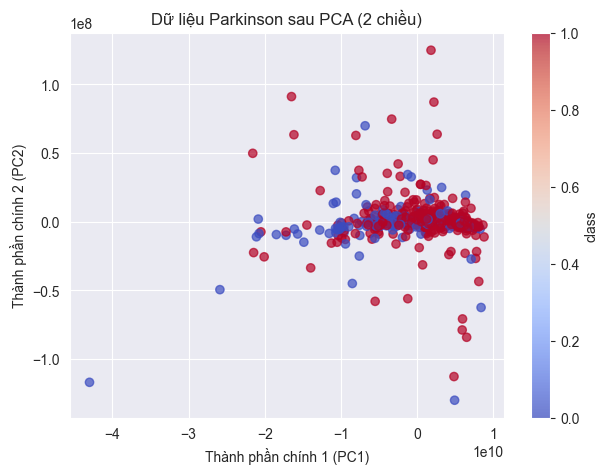

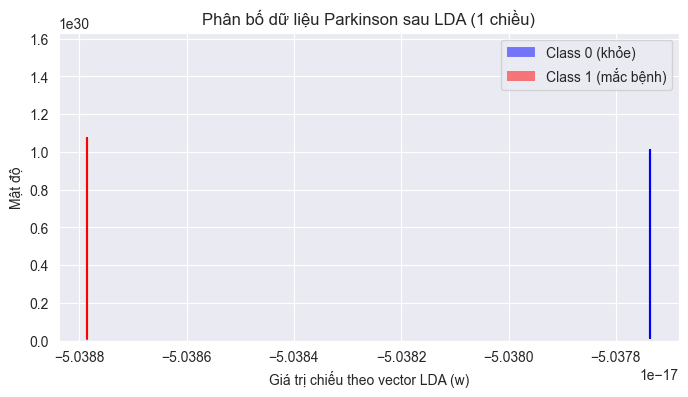

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Vẽ dữ liệu PCA (2D) 
plt.figure(figsize=(7,5))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap='coolwarm', alpha=0.7)
plt.title("Dữ liệu Parkinson sau PCA (2 chiều)")
plt.xlabel("Thành phần chính 1 (PC1)")
plt.ylabel("Thành phần chính 2 (PC2)")
plt.colorbar(label='class')
plt.show()

# Vẽ dữ liệu LDA (1D) 
plt.figure(figsize=(8,4))
sns.histplot(X_train_lda[y_train==0], color='blue', label='Class 0 (khỏe)', kde=True, stat='density', bins=30, alpha=0.5)
sns.histplot(X_train_lda[y_train==1], color='red', label='Class 1 (mắc bệnh)', kde=True, stat='density', bins=30, alpha=0.5)
plt.title("Phân bố dữ liệu Parkinson sau LDA (1 chiều)")
plt.xlabel("Giá trị chiếu theo vector LDA (w)")
plt.ylabel("Mật độ")
plt.legend()
plt.show()
